In [1]:
%matplotlib widget
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def json_fn_to_dict(fn):
    with open(fn, "r") as f:
        d = json.load(f)

    d["log_name"] = fn.stem
    d["x"] = pd.to_datetime(d["x"])    
    
    if "HPTED" in fn.stem:
        d["model"] = "TunedRF"

    return d

def add_tc(d):
    trained_on = d["trained_on"][0]

    if "_TC=" not in trained_on:
        tc = 1
    else:
        # h=18_residential_2018_WITH_PV_SFH15_TC=48_2018.csv"
        tc_str = trained_on.split("_")
        tc_str = [foo for foo in tc_str if "TC=" in foo][0]
        tc = int(tc_str[3:])


    d["time_compression"] = [tc]
    return d

def calc_core_corrected_time_to_fit(d):

    model_type = d["model"][0]
    time_to_fit = d["time_to_fit"][0]

    core_corrected_time_to_fit = ...
    if model_type == "CustomLSTM":
        core_corrected_time_to_fit = time_to_fit * 5.5  # experiments showed that LSTM used approximately 550% cores 

    elif model_type == "CustomRandomForest":
        core_corrected_time_to_fit = time_to_fit * 6.5 

    elif model_type == "TunedRF":
        core_corrected_time_to_fit = time_to_fit * 10 

    elif model_type == "CustomSARIMAX":

        dt_str_format = "'%a %b %d %H:%M:%S %Y'"
        time_of_start = d['time_before_fit'][0]
        time_of_start = datetime.datetime.strptime(time_of_start, dt_str_format)

        time_when_n_cores_changed = datetime.datetime(2022, 11, 18, 9, 10)

        if time_of_start < time_when_n_cores_changed:
            core_corrected_time_to_fit = time_to_fit * 16.5

        else:
            core_corrected_time_to_fit = time_to_fit * 39.5

    elif model_type == "CustomProphet":
        core_corrected_time_to_fit = time_to_fit * 1.5 

    elif model_type == "CustomNaiveYesterday":
        core_corrected_time_to_fit = time_to_fit * 1
    
    elif model_type == "CustomNaiveLastWeek":
        core_corrected_time_to_fit = time_to_fit * 1

    else:
        raise NotImplementedError(f"Error! {model_type} is not implemented")

    d["core_corrected_time_to_fit"] = [core_corrected_time_to_fit]

    return d

def add_metric(d, metric_name, metric_func):
    y, yhat = d["y"][0], d["yhat"][0]

    train_y, train_yhat = d["train_y"][0], d["train_yhat"][0]
    test_y, test_yhat = d["test_y"][0], d["test_yhat"][0]

    d[f"{metric_name}"] = [metric_func(y, yhat)]
    d[f"{metric_name}_train"] = [metric_func(train_y, train_yhat)]
    d[f"{metric_name}_test"] = [metric_func(test_y, test_yhat)]

    return d

def add_split_train_eval(d):
    x, y, yhat = d["x"][0], d["y"][0], d["yhat"][0]
    # assert len(y) == len(yhat)
    n = int(len(y)*d['train_eval_split'][0])

    train_x, train_y, train_yhat = x[:n], y[:n], yhat[:n]
    test_x, test_y, test_yhat = x[n:], y[n:], yhat[n:]

    train_y = [float(_y) for _y in train_y]
    train_yhat = [float(_y) for _y in train_yhat]
    test_y = [float(_y) for _y in test_y]
    test_yhat = [float(_y) for _y in test_yhat]

    d["train_x"] = [train_x]
    d["train_y"] = [train_y]
    d["train_yhat"] = [train_yhat]

    d["test_x"] = [test_x]
    d["test_y"] = [test_y]
    d["test_yhat"] = [test_yhat]

    return d

def add_errors(d):
    for prefix in ["", "test_", "train_"]:
        y, yhat = d[f"{prefix}y"][0], d[f"{prefix}yhat"][0]
        error = [_y - _yh for _y, _yh in zip(y, yhat)]
        d[f"{prefix}error"] = [error]
        error = np.array(error)

        d[f"{prefix}error_mean"] = float(np.mean(error))
        d[f"{prefix}error_std"] = float(np.std(error))

    return d

def add_metrics(d):
    d = add_metric(d, metric_name="r2", metric_func=r2_score)
    d = add_metric(d, metric_name="mse", metric_func=mean_squared_error)
    d = add_metric(d, metric_name="mae", metric_func=mean_absolute_error)
    d = add_metric(d, metric_name="mape", metric_func=mean_absolute_percentage_error)

    return d
  
def add_binary_classification(d):
    trained_on = d["trained_on"][0]

    if "industrial" in trained_on:
        classification = "industrial"
    elif "residential" in trained_on:
        classification = "residential"
    elif "aggregate" in trained_on:
        classification = "aggregate"

    else:
        raise NotImplementedError(f"trained_on = {trained_on}")

    d["binary_classification"] = [classification]
    return d

def add_trinary_classification(d):
    trained_on = d["trained_on"][0]

    if "industrial" in trained_on:
        classification = "industrial"
    elif "NO_PV" in trained_on:
        classification = "NO_PV"
    elif "WITH_PV" in trained_on:
        classification = 'WITH_PV'
        
    elif "aggregate" in trained_on:
        classification = "aggregate"

    else:
        raise NotImplementedError(f"trained_on = {trained_on}")

    d["trinary_classification"] = [classification]
    return d
    
def prep_dict(d):
    d = {k: [v] for k, v in d.items()}

    d["trained_on"] = [Path(d["data_source_path"][0]).stem]

    d["log_ID"] = [int(d["log_name"][0].split("_")[0])]

    d = add_file_end(d)

    d = add_horizon(d)

    d = add_binary_classification(d)

    d = add_trinary_classification(d)

    d = calc_core_corrected_time_to_fit(d)

    d = add_split_train_eval(d)

    d = add_errors(d)
    
    d = add_metrics(d)

    d = update_model(d)

    d = add_tc(d)

    return d

def update_model(d):
    model = d["model"][0]

    if model.startswith("Custom"):
        model = model[6:]

    d["model"] = [model]
    return d

def add_horizon(d):
    x = d["trained_on"][0] #  x = 'h=4_industrial_2016_LG_4'
    
    x = x.split("_")[0] # x = "h=4"

    x = x[2:]  # x = "4"

    x = int(x)

    d["horizon"] = [x]

    return d

def add_file_end(d):
    trained_on = d["trained_on"][0]

    foo = trained_on.split("_")

    foo = ("_").join(foo[1:])

    d["file_end"] = [foo]

    return d


def lazy_prep_dict(fn):
    d = json_fn_to_dict(fn)
    d = prep_dict(d)

    return d


def dicts_to_df(dicts):
    df = pd.DataFrame(dicts[0])

    for d in dicts[1:]:
        # make the new dataframe
        new_df = pd.DataFrame(d)

        # if not all columns of the new df are in the old df:
        for c in new_df.columns:
            if c not in df.columns:
                df[c] = [np.nan]*len(df)

        # if not all columns of the old df are in the new df:
        for c in df.columns:
            if c not in new_df.columns:
                new_df[c] = [np.nan]

        assert all(c in new_df.columns for c in df)
        assert all(c in df.columns for c in new_df)

        df = pd.concat([df, new_df], ignore_index=True)

    return df

def string_to_list_of_numbers(string):
    assert string[0] == "["
    assert string[-1] == "]"
    string = string[1:-1]
    strings = string.split(",")

    floats = [float(string) for string in strings]
    return floats

def string_to_list_of_datetimes(string):
    dt_str_format = "'%Y-%m-%d %H:%M:%S'"
    string = string.split("]")[0]
    string = string.split("[")[1]

    strings = string.split(",")
    strings = [string.strip("...") for string in strings]
    strings = [string.strip("\n") for string in strings]
    strings = [string.strip(" ") for string in strings]

    dts = [datetime.datetime.strptime(dt_str, dt_str_format) for dt_str in strings]
    return dts
    
def fix_loaded_df(df):
    df = df.drop(columns='Unnamed: 0')
    df["x"] = [string_to_list_of_datetimes(x) for x in df["x"]]
    df["y"] = [string_to_list_of_numbers(y) for y in df["y"]] 
    df["yhat"] = [string_to_list_of_numbers(y) for y in df["yhat"]] 
     
    return df
    

In [2]:
COLORS = {"LSTM": "green", "Prophet": "orange", "RandomForest": "cyan", "TunedRF": "red", "SARIMAX": "red", "NaiveLastWeek": "navy", "NaiveYesterday": "magenta"}
FIGURE_DIR = Path(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\00_Programming\forecasting\figures")
MARKERS = {"LSTM": "x", "Prophet": "o", "RandomForest": "d", "TunedRF": ".", "SARIMAX": ".", "NaiveLastWeek": "^", "NaiveYesterday": "v"}

In [3]:
LOAD_EXISTING_LOGS = False

if LOAD_EXISTING_LOGS:
    full_df = pd.read_csv(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\00_Programming\forecasting\datasets\processed_logs.csv")
    full_df = fix_loaded_df(full_df)
else:
    log_dir = Path(r"C:\Users\Flin\OneDrive - TU Eindhoven\Flin\Flin\01 - Uni\00_Internship\Nokia\00_Programming\forecasting\logs")
    fns = [fn for fn in log_dir.iterdir() if fn.is_file()]
    fns = [fn for fn in fns if "HPTED" in fn.stem]
    
    ds = [lazy_prep_dict(fn) for fn in fns]
    full_df = dicts_to_df(ds)

full_df.shape, full_df.columns


((260, 57),
 Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
        'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
        'n_estimators', 'n_jobs', 'max_features', 'max_samples', 'n_cores',
        'ts2row_history_window', 'only_fit_using_last_n_weeks',
        'rolling_prediction', 'tiny_test', 'os', 'time_at_saving', 'log_name',
        'trained_on', 'log_ID', 'file_end', 'binary_classification',
        'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
        'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'error',
        'error_mean', 'error_std', 'test_error', 'test_error_mean',
        'test_error_std', 'train_error', 'train_error_mean', 'train_error_std',
        'r2', 'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
        'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
        'time_compression'],
       dtype='object'))

# Analyze

## Qualitative analysis
- plot the performance if several agents in exactly the same file
- Study the performance

In [4]:
filenames = ["h=1_industrial_2016_LG_8",
"h=1_residential_2018_NO_PV_SFH9_2018",
"h=1_residential_2019_WITH_PV_SFH15_2018",
"h=12_industrial_2016_LG_18",
"h=12_residential_2018_NO_PV_SFH17_2018",
"h=12_residential_2019_WITH_PV_SFH15_2019"]

columns_of_interest = ["x", "y", "yhat", "time_to_predict", "model", 'core_corrected_time_to_fit', 'r2', 'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test', "train_eval_split"]
       
fn = filenames[0]

In [5]:
#df = full_df[full_df["trained_on"]==fn]
model_df = full_df[full_df["model"].isin(["TunedRF"])]
#model_df = full_df[full_df["model"].isin(["RandomForest", "Prophet", "LSTM", "NaiveLastWeek", "NaiveYesterday"])]
model_df.shape

(260, 56)

In [6]:
def add_limits(ax, train_x, test_x, only_show_test_results, remove_last_n_days=0, only_show_last_n_days=0):
    if only_show_last_n_days and only_show_last_n_days:
        print("Both 'only_show_last_n_days' and 'only_show_last_n_days' are used, defaulting to 'only_show_last_n_days'")

    x = [x for x in train_x] + [x for x in test_x]
    td = (x[1] - x[0]).total_seconds()

    if remove_last_n_days:
        remove_last_n_rows = int(remove_last_n_days*24*3600 / td)

        if remove_last_n_rows > len(x):
            print("IGNORING remove_last_n_rows, since: 'remove_last_n_rows) > len(x)'") 

        else:
            x = x[-remove_last_n_rows:]

    if only_show_last_n_days:
        show_last_n_rows = int(only_show_last_n_days*24*3600 / td)
        x = x[-show_last_n_rows:]

    if only_show_test_results:
        if len(x) < len(train_x):
            print("IGNORING only_show_test_results, since: 'len(x) < len(train_x)', i.e. too much truncated already")
        else:
            x = x[len(train_x):]

    ax.set_xlim([x[0], x[-1]])
    return ax


def draw_x_and_y(ax, dic, title_prefix=None, only_show_last_n_weeks=0):
    train_x, test_x = dic["train_x"], dic["test_x"]
    #train_x, test_x = pd.to_datetime(train_x), pd.to_datetime(test_x)

    train_y, test_y = dic["train_y"], dic["test_y"]
    train_yhat, test_yhat = dic["train_yhat"], dic["test_yhat"]

    model = dic["model"]

    ax.plot(train_x, train_y, color="blue", label="y")
    ax.plot(train_x, train_yhat, color="red", label="yhat")

    ax.plot(test_x, test_y, color="blue")
    ax.plot(test_x, test_yhat, color="red")

    ax.vlines(test_x[0], min(min(train_y), min(test_y)), max(max(train_y), max(test_y)), color="black")

    ax = add_limits(ax, train_x, test_x, only_show_test_results=True, remove_last_n_days=7, only_show_last_n_days=0)



    if title_prefix is None:
        title = model
    else:
        title = f"{title_prefix}_{model}"


    ax.set_title(title)
    ax.grid()
    ax.legend()

    return ax

def draw_error(ax, dic, title_prefix=None, only_show_last_n_weeks=0):
    train_x, test_x = dic["train_x"], dic["test_x"]
    #train_x, test_x = pd.to_datetime(train_x), pd.to_datetime(test_x)

    train_y, test_y = dic["train_y"], dic["test_y"]
    train_yhat, test_yhat = dic["train_yhat"], dic["test_yhat"]

    model = dic["model"]

    assert len(train_y) == len(train_yhat)
    train_error = [_y - _yh for _y, _yh in zip(train_y, train_yhat)]

    assert len(test_y) == len(test_yhat)
    test_error = [_y - _yh for _y, _yh in zip(test_y, test_yhat)]
    

    ax.plot(train_x, train_error, color="red", label="y-yhat")
    ax.plot(test_x, test_error, color="red")

    ax = add_limits(ax, train_x, test_x, only_show_test_results=True, remove_last_n_days=7, only_show_last_n_days=0)


    if title_prefix is None:
        title = model
    else:
        title = f"{title_prefix}_{model}"

    ax.set_title(title)
    ax.grid()
    ax.legend()

    return ax

Skipping h=1_residential_2019_WITH_PV_SFH15_2018


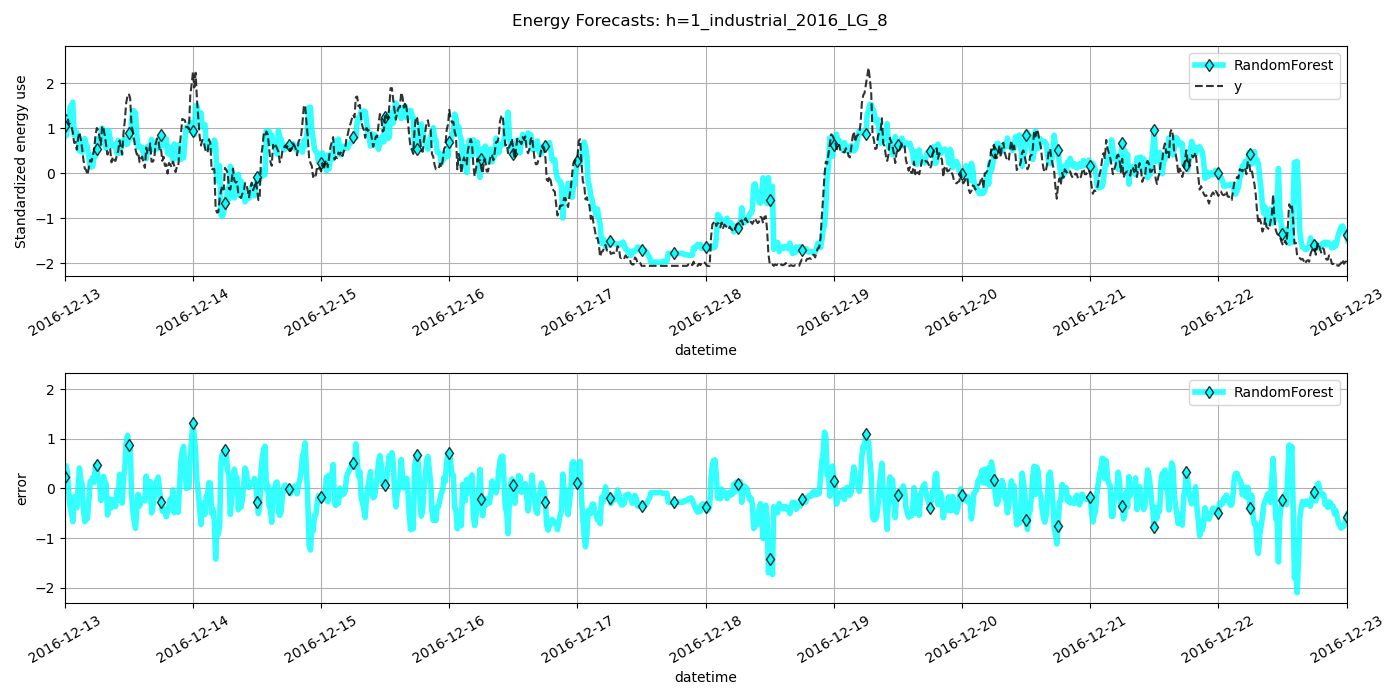

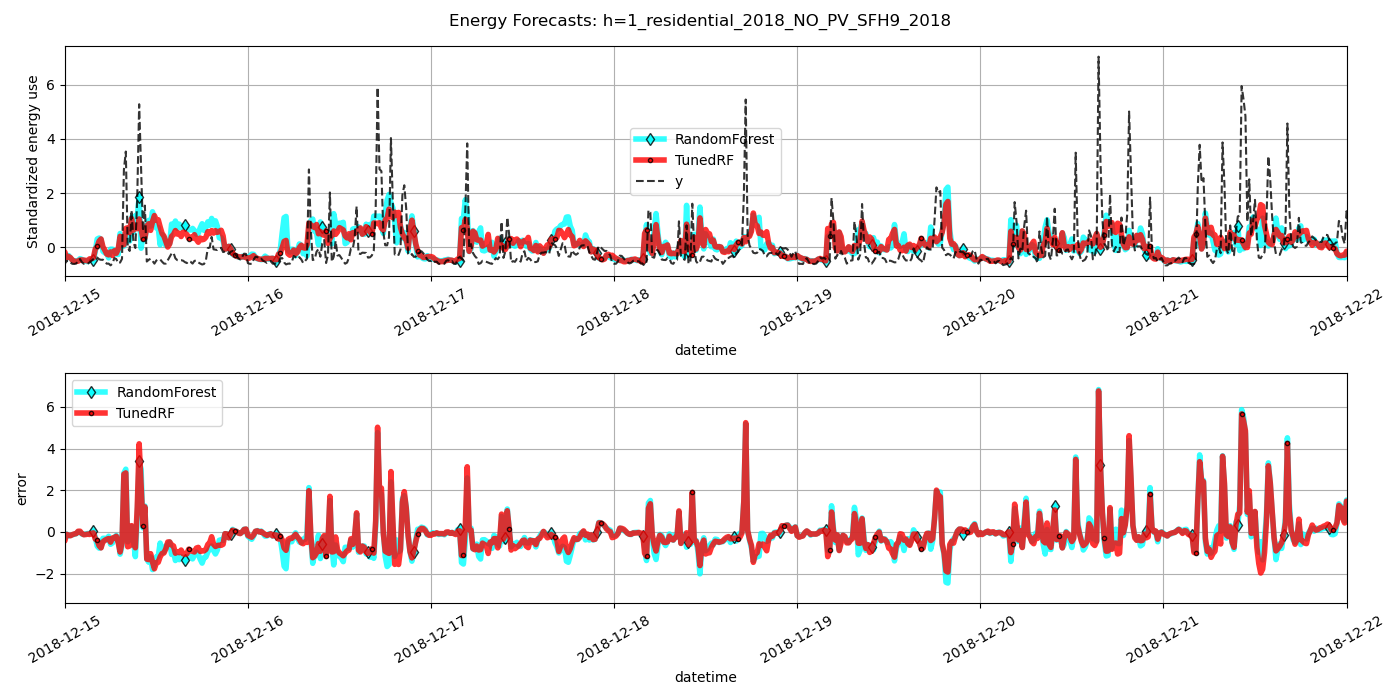

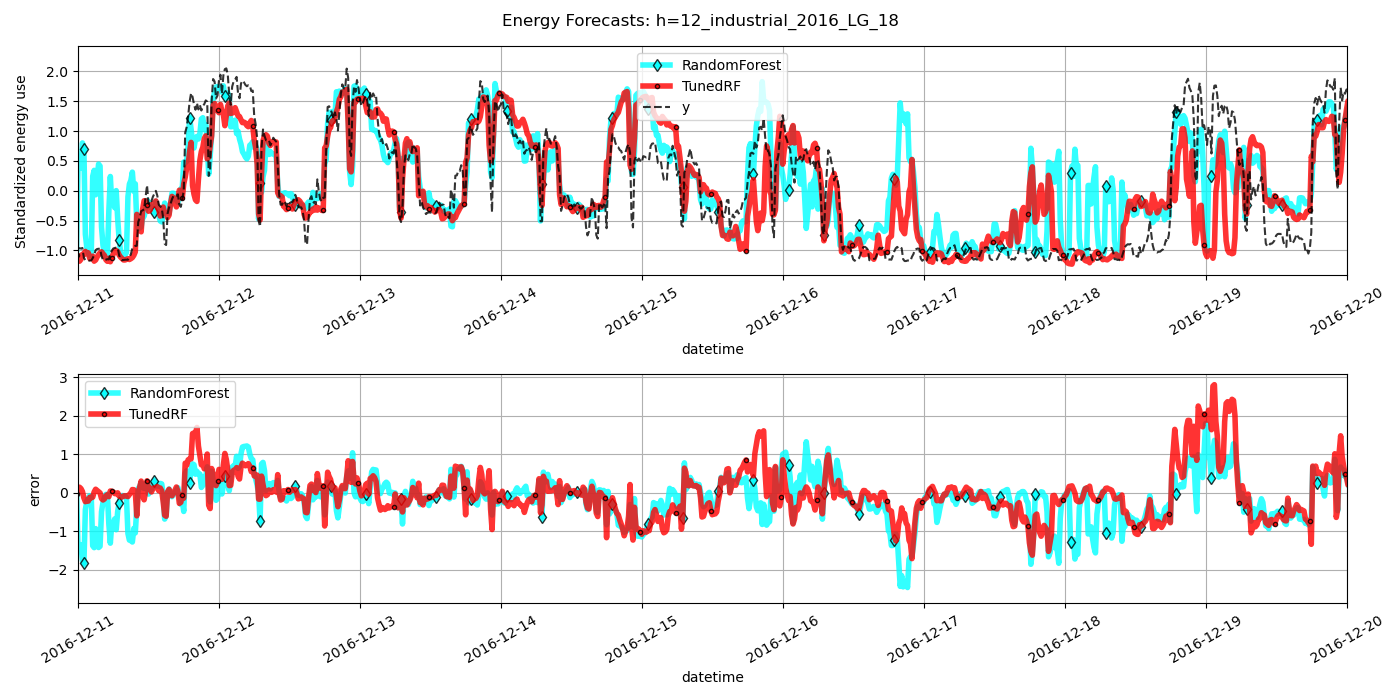

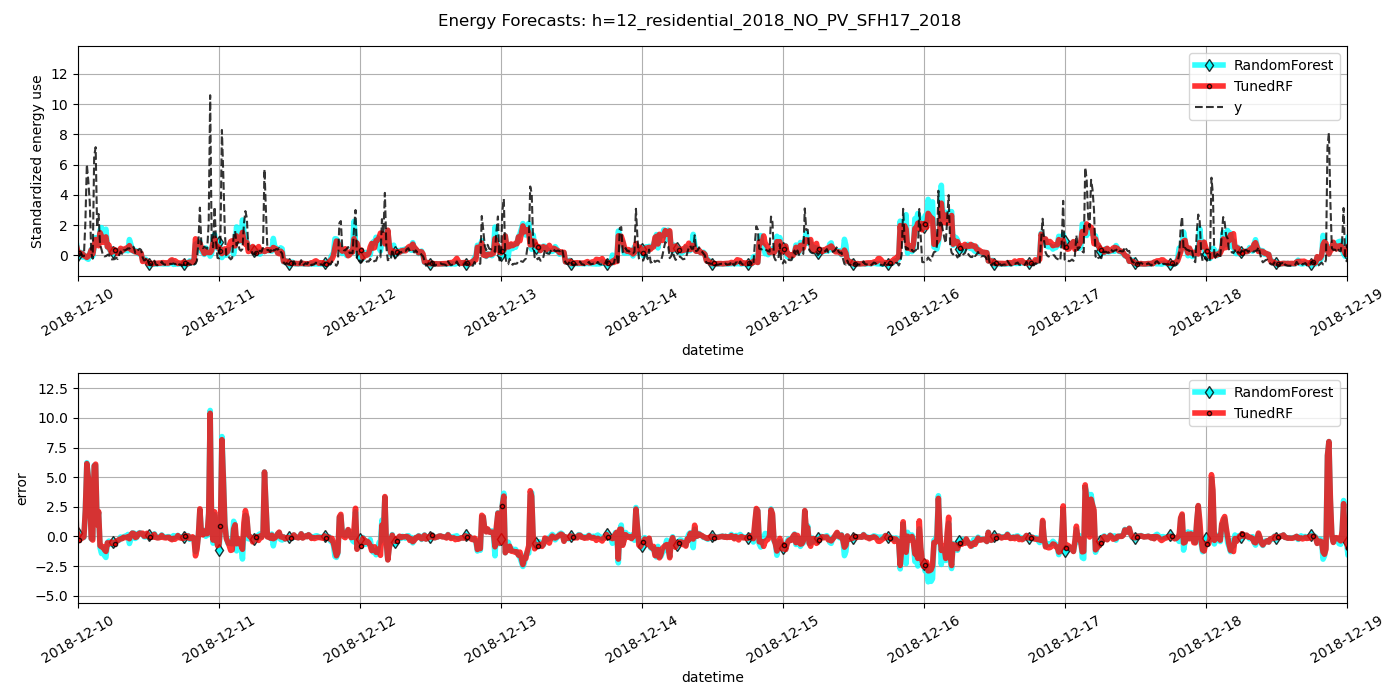

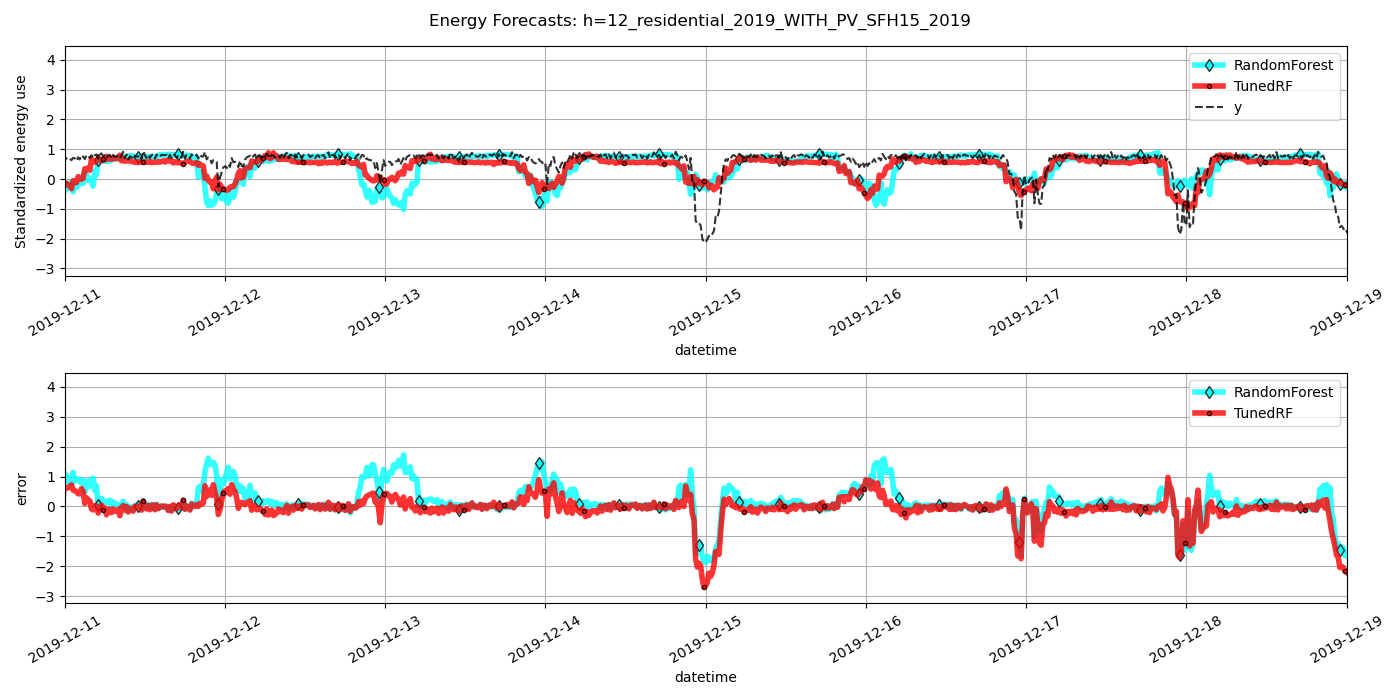

In [15]:
fn_to_xlim = {'h=1_industrial_2016_LG_8': [datetime.datetime(2016, 12, 13), datetime.datetime(2016, 12, 23)],
 'h=1_residential_2018_NO_PV_SFH9_2018':  [datetime.datetime(2018, 12, 15), datetime.datetime(2018, 12, 22)],
 'h=1_residential_2019_WITH_PV_SFH15_2018': None,
 'h=12_industrial_2016_LG_18': [datetime.datetime(2016, 12, 11), datetime.datetime(2016, 12, 20)],
 'h=12_residential_2018_NO_PV_SFH17_2018':  [datetime.datetime(2018, 12, 10), datetime.datetime(2018, 12, 19)],
 'h=12_residential_2019_WITH_PV_SFH15_2019': [datetime.datetime(2019, 12, 11), datetime.datetime(2019, 12, 19)],}

SKIP_MODELS = ["NaiveLastWeek", "NaiveYesterday"]  # ["LSTM", "Prophet", "RandomForest"]  # 
SAVEFIG = False

for fn in filenames:
    longest_y = []

    sub_df = model_df[model_df["trained_on"]==fn]

    n = sub_df.shape[0]

    if n == 0:
        print(f"Skipping {fn}")
        continue

    fig, axs = plt.subplots(2, figsize=(14, 7))
    fig.suptitle(f"Energy Forecasts: {fn}")

    for ax in axs:
        if fn_to_xlim[fn] is None:
            continue
            
        ax.set_xlim(fn_to_xlim[fn])


    for i, (idx, row) in enumerate(sub_df.iterrows()):
        model = row["model"]

        if model in SKIP_MODELS:
            continue
        
        x = row["test_x"]
        yhat = list(row["test_yhat"])
        y = list(row["test_y"])
        error = [_y - _yh for _y, _yh in zip(y, yhat)]

        
        axs[0].plot(x, yhat, label=model, color=COLORS[model], alpha=0.8, marker=MARKERS[model], linewidth=4, markevery=4*6, markeredgecolor="black")
        axs[1].plot(x, error, label=model, color=COLORS[model], alpha=0.8, marker=MARKERS[model], linewidth=4, markevery=4*6, markeredgecolor="black")


        if len(y) > len(longest_y):
            longest_x = x
            longest_y = y

    axs[0].plot(longest_x, longest_y, label="y", linestyle="dashed", alpha=0.8, color="black", zorder=10)

    axs[0].set_ylabel("Standardized energy use")
    axs[1].set_ylabel("error")

    for ax in axs:
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=30 )

        # ax.set_xticklabels(ax.get_xticks(), rotation = 50)
        ax.legend()
        ax.grid()
        ax.set_xlabel("datetime")

    fig.tight_layout()
    
    if SAVEFIG:
        plt.savefig(FIGURE_DIR / f"pred_and_error_{fn}")

In [ ]:
file_ends = ['industrial_2016_LG_2', 'residential_2018_NO_PV_SFH4_2018', 'residential_2018_WITH_PV_SFH15_2018']
horizons = [1, 2, 4, 6, 12, 18]
rf_df = model_df[model_df["model"] == "RandomForest"]


fe_to_xlim = {'industrial_2016_LG_2': [datetime.datetime(2016, 11, 1), datetime.datetime(2016, 11, 8)],
              'residential_2018_NO_PV_SFH4_2018': [datetime.datetime(2018, 12, 8), datetime.datetime(2018, 12, 11)], 
              'residential_2018_WITH_PV_SFH15_2018': [datetime.datetime(2018, 12, 9), datetime.datetime(2018, 12, 12)]}

SAVEFIG = False
LW = 2

for fe in file_ends:
    longest_y = []

    rf_fe_df = rf_df[rf_df["file_end"]==fe]

    if len(rf_fe_df) == 0:
        print(f"Skipping {fe}")
        continue

    fig, axs = plt.subplots(2, figsize=(10, 7))
    fig.suptitle(f"Energy Forecasts per horizon: {fe}")

    for ax in axs:
        if fe_to_xlim[fe] is None:
            continue
            
        ax.set_xlim(fe_to_xlim[fe])


    for h in horizons:
        row = rf_fe_df[rf_fe_df["trained_on"]==f"h={h}_{fe}"]
        if len(row) == 0:
            print(f"Skipping {fe}, h={h}")
            continue

        assert len(row) == 1

        row = row.iloc[0]
        model = row["model"]

        nr = 4*h

        x = row["test_x"][nr:]
        yhat = list(row["test_yhat"])[:-nr]

        if isinstance(yhat, str):
            assert yhat[0] == "["
            assert yhat[-1] == "]"
            yhat = [float(_y) for _y in yhat[1:-1]]


        y = list(row["test_y"])[:-nr]

        if isinstance(y, str):
            assert y[0] == "["
            assert y[-1] == "]"
            y = [float(_y) for _y in y[1:-1]]
    
        error = [_y - _yh for _y, _yh in zip(y, yhat)]

        
        axs[0].plot(x, yhat, label=f"h={h}", alpha=0.8, linewidth=LW, markevery=4*6, markeredgecolor="black")
        axs[1].plot(x, error, label=f"h={h}", alpha=0.8, linewidth=LW, markevery=4*6, markeredgecolor="black")


        if len(y) > len(longest_y):
            longest_x = x
            longest_y = y

    axs[0].plot(longest_x, longest_y, label="y", linestyle="dashed", alpha=0.8, color="black", zorder=10)

    axs[0].set_ylabel("Standardized energy use")
    axs[1].set_ylabel("error")

    for ax in axs:
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=30 )

        # ax.set_xticklabels(ax.get_xticks(), rotation = 50)
        ax.legend()
        ax.grid()
        ax.set_xlabel("datetime")

    fig.tight_layout()
    
    if SAVEFIG:
        plt.savefig(FIGURE_DIR / f"pred_and_error_over_h_fe={fe}")

In [ ]:

for fn in filenames:
    longest_y = []

    sub_df = model_df[model_df["trained_on"]==fn]

    n = sub_df.shape[0]

    if n == 0:
        print(f"Skipping {fn}")
        continue

    fig, axs = plt.subplots(2, figsize=(9, 8))
    fig.suptitle(fn)

    for ax in axs:
        if fn_to_xlim[fn] is None:
            continue
            
    for i, (idx, row) in enumerate(sub_df.iterrows()):
        model = row["model"]
        x = row["x"]
        yhat = list(row["yhat"])
        y = list(row["y"])
        error = [_y - _yh for _y, _yh in zip(y, yhat)]

        x_vline = x[int(row["train_eval_split"]*len(x))]

        axs[0].plot(x, yhat, label=model, color=COLORS[model], alpha=0.8, marker=MARKERS[model], markevery=4*6, markeredgecolor="black")
        axs[1].plot(x, error, label=model, color=COLORS[model], alpha=0.8, marker=MARKERS[model], markevery=4*6, markeredgecolor="black")

        
        axs[0].vlines(x_vline, ymin=min(y), ymax=max(y), color="black", linewidth=3)
        axs[0].vlines(x_vline, ymin=min(y), ymax=max(y), color=COLORS[model], linewidth=1.5)

        axs[1].vlines(x_vline, ymin=min(error), ymax=max(error), color="black", linewidth=3)
        axs[1].vlines(x_vline, ymin=min(error), ymax=max(error), color=COLORS[model], linewidth=1.5)

        if len(y) > len(longest_y):
            longest_x = x
            longest_y = y

    axs[0].plot(longest_x, longest_y, label="y", linestyle="dashed", alpha=0.8, color="black", zorder=10)

    axs[0].set_ylabel("Predictions")
    axs[1].set_ylabel("Prediction error")

    for ax in axs:
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=30 )

        # ax.set_xticklabels(ax.get_xticks(), rotation = 50)
        ax.legend()
        ax.grid()
        ax.set_xlabel("datetime")

    fig.tight_layout()
    # plt.savefig(FIGURE_DIR / f"pred_and_error_{fn}")

In [ ]:
sub_df

## Quantitative analysis
- plot heatmap of [fn]x[model], for each metric, at each horizon
- Plot degradation of metric over horizon

In [ ]:
# for metric in ["r2_test", "mse_test", "mae_test", 'core_corrected_time_to_fit']:
#     row_index = "trained_on"
#     col_index = "model"

#     if pivot_table:
#         table = pd.pivot_table(model_df, values=metric, index=[row_index], columns=[col_index])

#     else:
#         table = model_df
    

#     if drop_SARIMAX:
#         if "CustomSARIMAX" in table.columns:
#             table = table.drop(columns="CustomSARIMAX")

#     fig, ax = plt.subplots(figsize=(10, 5))
#     fig.suptitle(metric)
#     if pivot_table:
#         ax = sns.boxplot(table, ax=ax)
#     else:
#         ax = sns.boxplot(data=table, x="model", y=metric, hue="trinary_classification")
    
#     ax.grid()


In [7]:
model_df.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'n_estimators', 'n_cores', 'ts2row_history_window',
       'only_fit_using_last_n_weeks', 'rolling_prediction', 'tiny_test', 'os',
       'time_at_saving', 'log_name', 'trained_on', 'log_ID', 'file_end',
       'binary_classification', 'trinary_classification',
       'core_corrected_time_to_fit', 'train_x', 'train_y', 'train_yhat',
       'test_x', 'test_y', 'test_yhat', 'error', 'error_mean', 'test_error',
       'test_error_mean', 'train_error', 'train_error_mean', 'r2', 'r2_train',
       'r2_test', 'mse', 'mse_train', 'mse_test', 'mae', 'mae_train',
       'mae_test', 'mape', 'mape_train', 'mape_test', 'n_jobs', 'max_features',
       'max_samples'],
      dtype='object')

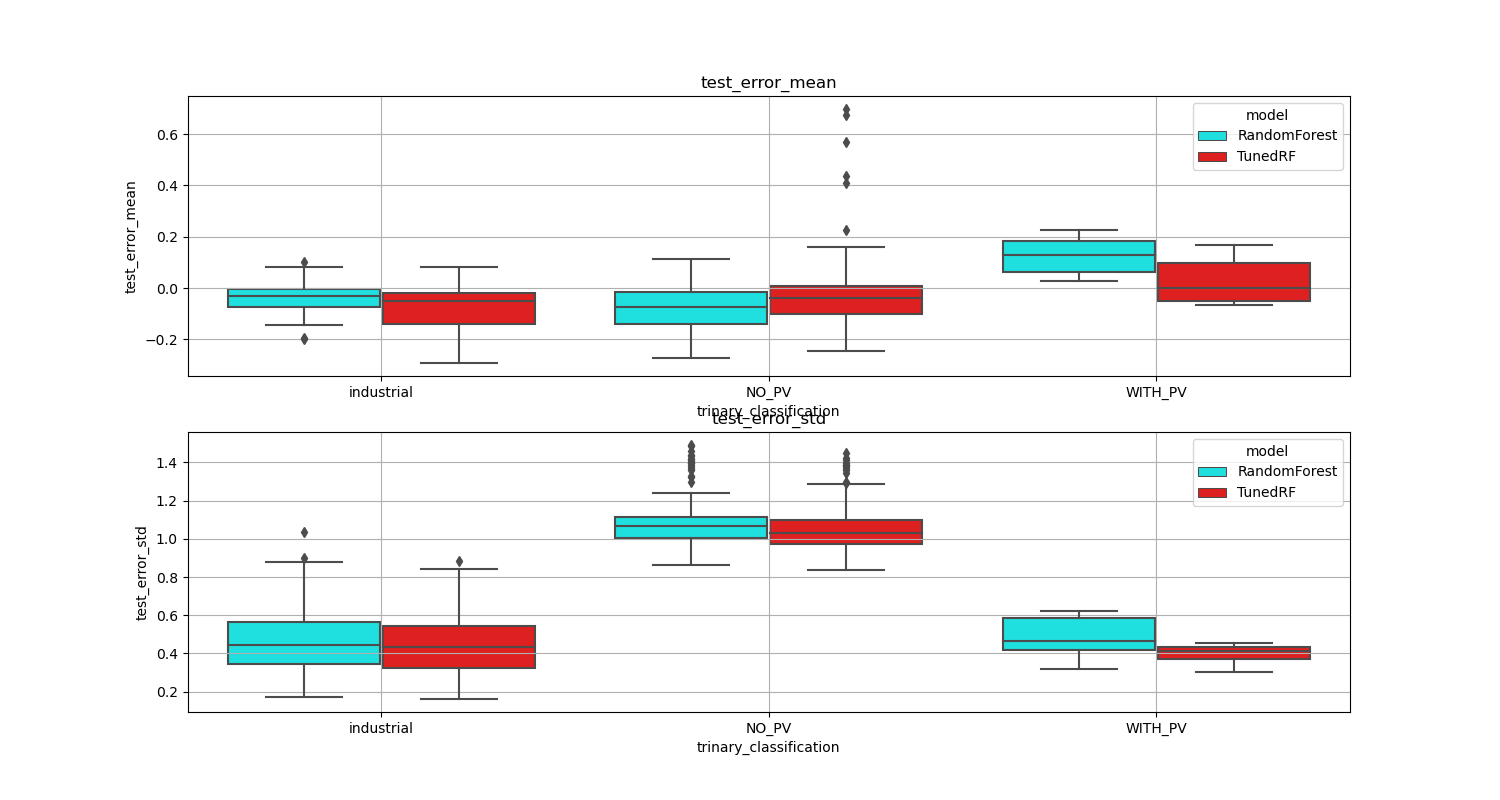

In [13]:
metrics_to_ylims = {'test_error_mean': None,
                    'test_error_std': None}


fig, axs = plt.subplots(2, figsize=(15, 8))

for ax, metric in zip(axs, list(metrics_to_ylims.keys())):

    ax.set_title(metric)
    ax = sns.boxplot(data=model_df, x="trinary_classification", y=metric, hue="model", palette=COLORS, ax=ax)
    
    if metrics_to_ylims[metric] is not None:
        ax.set_ylim(metrics_to_ylims[metric])

    ax.grid()

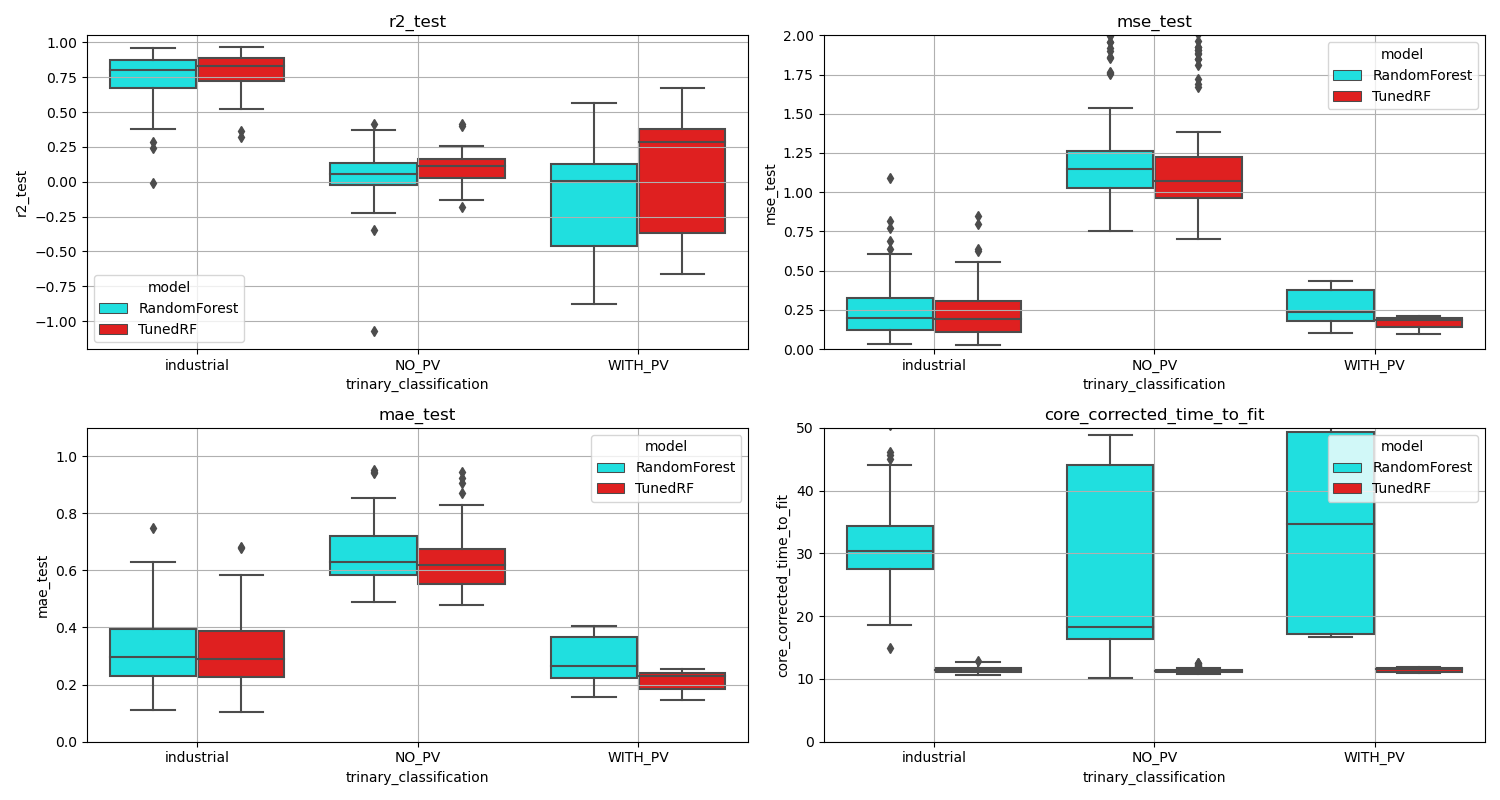

In [19]:
metrics_to_ylims = {"r2_test": [-1.2, 1.05],
                    "mse_test": [0, 2.0],
                    "mae_test": [0, 1.1],
                    "mape_test": [0, 30], 
                    'core_corrected_time_to_fit': [0,50]}

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
new_axs = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]

for ax, metric in zip(new_axs, ["r2_test", "mse_test", "mae_test", 'core_corrected_time_to_fit']):
    row_index = "trained_on"
    col_index = "model"

    ax.set_title(metric)
    ax = sns.boxplot(data=model_df, x="trinary_classification", y=metric, hue="model", palette=COLORS, ax=ax)
    
    if metrics_to_ylims[metric] is not None:
        ax.set_ylim(metrics_to_ylims[metric])


    ax.grid()
fig.tight_layout()

In [ ]:
model_df.columns

In [ ]:
fig, axs = plt.subplots(3, figsize=(10, 10))

metrics_to_ylims = {"r2": [-2, 1], "mae": [0, 2], "mse": [0, 5]}

for ax, metric in zip(axs, ["r2", "mae", "mse"]):

    
    test_df = model_df[["model", f"{metric}_test"]]
    test_df.rename(columns={f"{metric}_test": metric}, inplace=True)
    test_df["type"] = test_df.shape[0]*["test"]

    train_df = model_df[["model", f"{metric}_train"]]
    train_df.rename(columns={f"{metric}_train": metric}, inplace=True)
    train_df["type"] = train_df.shape[0]*["train"]

    metric_df = pd.concat([train_df, test_df], ignore_index=True)

    ax = sns.boxplot(data=metric_df, x="model", y=metric, hue="type", ax=ax)
    ax.grid()

    if metrics_to_ylims[metric] is not None:
        ax.set_ylim(metrics_to_ylims[metric])

    



## Performance over horizon

In [ ]:
models = list(model_df["model"].unique())
file_endings = list(model_df["file_end"].unique())
metric = "r2_test"

for file_end in file_endings:
    file_df = model_df[model_df["file_end"]==file_end]

    fig, ax = plt.subplots()

    for model in models:
        model_file_df = file_df[file_df["model"] == model]

        horizon_metric_list = [[r["horizon"], r[metric]] for _, r in model_file_df.iterrows()]
        horizon_metric_list.sort(key = lambda x: x[0])

        x = [x[0] for x in horizon_metric_list]
        y = [x[1] for x in horizon_metric_list]

        ax.plot(x, y, marker="x", label=model)
    
    ax.legend()
    ax.grid()
    ax.set_title(file_end)
    ax.set_xlabel("horizon")
    ax.set_ylabel(metric)

    break


In [ ]:
cols = model_df.columns
metrics = [c for c in cols if c.endswith("test")]
metrics

In [ ]:
models = list(model_df["model"].unique())
file_endings = list(model_df["file_end"].unique())
horizons = list(model_df["horizon"].unique())
horizons.sort()
metrics = ['r2_test', 'mse_test', 'mae_test']

complete_dict = {}
fig, axs = plt.subplots(3, figsize=(8, 6))


for ax, metric in zip(axs, metrics):

    model_horizon_metric_dict = {m: {} for m in models}
    
    for horizon in horizons:
        horizon_df = model_df[model_df["horizon"] == horizon]

        for model in models:
            model_horizon_df = horizon_df[horizon_df["model"]==model]
            values = list(model_horizon_df[metric].values)
            
            if len(values) == 0:
                print(f"Skipping {model}, h={horizon}")
                continue

            mean = sum(values)/len(values)

            model_horizon_metric_dict[model][horizon] = mean

    for m, values in model_horizon_metric_dict.items():
        x = list(values.keys())
        y = list(values.values())

        ax.plot(x, y, marker=MARKERS[m], label=m, color=COLORS[m])

    ax.set_title(metric)
    ax.set_xlabel("Horizon")
    ax.set_ylabel(metric)
    ax.grid()
    ax.legend()
    fig.tight_layout()

    complete_dict[metric] = model_horizon_metric_dict


In [ ]:
model_df[["r2_test", "mae_test", "mse_test"]].describe()

In [ ]:
fig, axs = plt.subplots(3, figsize=(8, 6))

METRIC_TO_YLIMS = {"r2_test": [-2, 1.1],
                    "mse_test": [0, 4],
                    "mae_test": [0, 4],
                    "mape_test": [0, 30], 
                    'core_corrected_time_to_fit': [0,1000]}


for ax, metric in zip(axs, ["r2_test", "mse_test", "mae_test"]):
    row_index = "trained_on"
    col_index = "model"

    fig.suptitle(metric)

    ax = sns.swarmplot(data=model_df, x="horizon", y=metric, size=3, hue="model", order=list(model_df["horizon"].unique()).sort(), ax=ax)    

    if METRIC_TO_YLIMS[metric] is not None:
        ax.set_ylim(METRIC_TO_YLIMS[metric])


    ax.grid()

In [ ]:
fig, axs = plt.subplots(3, figsize=(12, 6))

new_model_df = model_df[model_df["model"].isin(["TunedRF", "RandomForest"])]

METRIC_TO_YLIMS = {"r2_test": [-2, 1.1],
                    "mse_test": [0, 4],
                    "mae_test": [0, 2],
                    "mape_test": [0, 30], 
                    'core_corrected_time_to_fit': [0,1000]}


for ax, metric in zip(axs, ["r2_test", "mse_test", "mae_test"]):
    row_index = "trained_on"
    col_index = "model"

    #ax = sns.boxplot(data=model_df, x="horizon", y=metric, hue="model", order=list(model_df["horizon"].unique()).sort(), ax=ax)  
    ax = sns.boxplot(data=new_model_df, x="model", y=metric, hue="horizon", hue_order=list(model_df["horizon"].unique()).sort(), ax=ax)   
 
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if METRIC_TO_YLIMS[metric] is not None:
        ax.set_ylim(METRIC_TO_YLIMS[metric])


    ax.grid()
fig.suptitle("Metrics as horizon extends")

In [42]:
def every_nth(arr, n=3):
    return arr[::n]

def compress_arr(arr, n=3):
    steps = len(arr) // n
    compr_arr = []
    for i in range(steps):
        v = sum(arr[i:(i+1)*n])
        compr_arr.append(v)

    return np.array(compr_arr)

def normalize(arr):
    return (arr - min(arr))/(max(arr) - min(arr))

In [43]:
N = 100
arr1 = normalize(np.random.randn(N))
arr2 = normalize(np.random.randn(N))
func = compress_arr


## Analyze time-compression

In [17]:
hdf = full_df[full_df["horizon"] == 18]

In [20]:
tcs = list(hdf["time_compression"].unique())
tcs.sort()
tcs

[1, 4, 12, 24, 48]

In [30]:
all_files = {}
for tc in tcs:
    tc_df = hdf[hdf["time_compression"] == tc]
    files = list(tc_df["trained_on"])
    all_files[tc] = files

In [32]:
"abaaa"

KeyError: 0

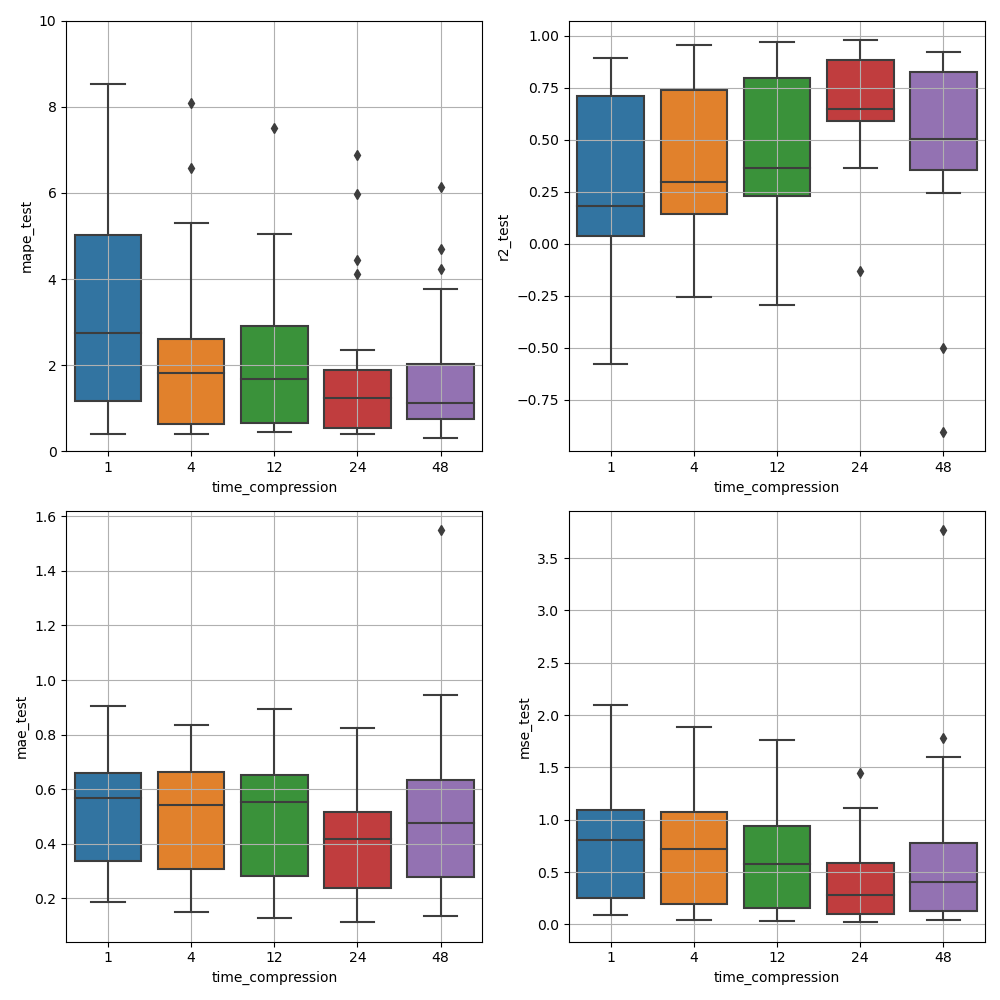

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
metrics_to_ylims = {"mape": [0, 10], "r2": None, "mae": None, "mse": None}

for ax, metric in zip(axs, ["mape", "r2", "mae", "mse"]):
    ax = sns.boxplot(data=hdf, x="time_compression", y=f"{metric}_test", ax=ax)
    ax.grid()

    if metrics_to_ylims[metric] is not None:
        ax.set_ylim(metrics_to_ylims[metric])

fig.tight_layout()

## Aggregate

In [4]:
full_df.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'n_estimators', 'n_jobs', 'max_features', 'max_samples', 'n_cores',
       'ts2row_history_window', 'only_fit_using_last_n_weeks',
       'rolling_prediction', 'tiny_test', 'os', 'time_at_saving', 'log_name',
       'trained_on', 'log_ID', 'file_end', 'binary_classification',
       'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
       'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'error',
       'error_mean', 'error_std', 'test_error', 'test_error_mean',
       'test_error_std', 'train_error', 'train_error_mean', 'train_error_std',
       'r2', 'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
       'time_compression'],
      dtype='object')

In [6]:
adf = full_df[full_df["binary_classification"] == 'aggregate']

In [45]:
HORIZONS = [1, 2, 4, 6, 12, 18]
YEARS = [2018, 2019]

results = {}
for metric in ["mse", "r2", "mae", "mape"]:
    metric = f"{metric}_test"

    aggr_values = {y: [] for y in YEARS}
    sep_values = {y: [] for y in YEARS}


    for year in YEARS:
        for horizon in HORIZONS:
            sub_adf = adf[adf["horizon"] == horizon]
            sub_adf = sub_adf[sub_adf["trained_on"].str.contains(str(year))]
            assert len(sub_adf) == 1

            sub_adf_mm = sub_adf[metric].values[0]  # mm=metric_mean
            aggr_values[year].append(sub_adf_mm)
            

            sub_df = full_df[full_df["trinary_classification"] == 'NO_PV']
            sub_df = sub_df[sub_df["horizon"] == horizon]
            sub_df = sub_df[sub_df["trained_on"].str.contains(str(year))]
            sub_df = sub_df[sub_df["time_compression"] == 1]
            print(len(sub_df))

            sub_df_values = sub_df[metric].values
            sub_df_mm = sum(sub_df_values)/len(sub_df_values)

            sep_values[year].append(sub_df_mm)

    results[metric] = {"aggr": aggr_values, "sep": sep_values}




7
7
7
7
7
7
6
6
6
6
6
6
7
7
7
7
7
7
6
6
6
6
6
6
7
7
7
7
7
7
6
6
6
6
6
6
7
7
7
7
7
7
6
6
6
6
6
6


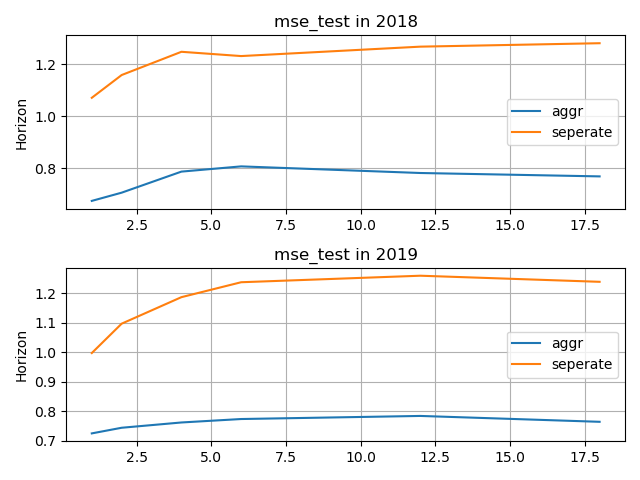

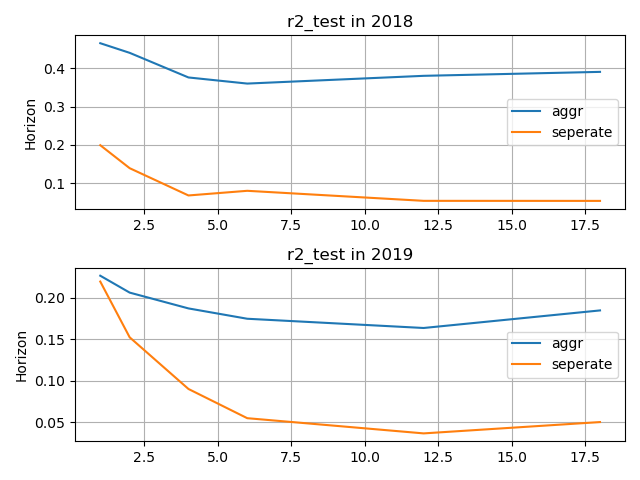

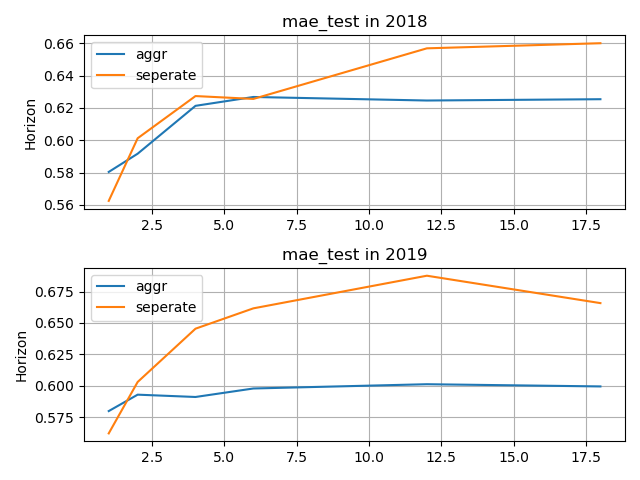

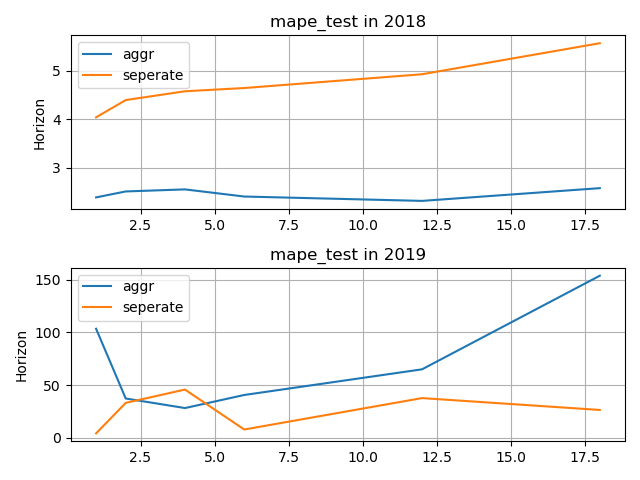

In [49]:
for metric, res in results.items():
    aggr_values, sep_values = res["aggr"], res["sep"]
    fig, axs = plt.subplots(2)
    for i, year in enumerate(YEARS):
        
        axs[i].plot(HORIZONS, aggr_values[year], label="aggr")
        axs[i].plot(HORIZONS, sep_values[year], label="seperate")
        
        axs[i].legend()
        axs[i].grid()
        
        axs[i].set_title(f"{metric} in {year}")
        axs[i].set_ylabel(f"{metric}")
        axs[i].set_ylabel(f"Horizon")

    fig.tight_layout()
    

In [25]:
sub_df_mm

1.0717092198602924

In [9]:
full_df["trinary_classification"].unique()

array(['industrial', 'NO_PV', 'WITH_PV', 'aggregate'], dtype=object)

In [10]:
adf.columns

Index(['time_before_fit', 'time_to_fit', 'x', 'y', 'time_to_predict', 'yhat',
       'features', 'data_source_path', 'horizon', 'model', 'train_eval_split',
       'n_estimators', 'n_jobs', 'max_features', 'max_samples', 'n_cores',
       'ts2row_history_window', 'only_fit_using_last_n_weeks',
       'rolling_prediction', 'tiny_test', 'os', 'time_at_saving', 'log_name',
       'trained_on', 'log_ID', 'file_end', 'binary_classification',
       'trinary_classification', 'core_corrected_time_to_fit', 'train_x',
       'train_y', 'train_yhat', 'test_x', 'test_y', 'test_yhat', 'error',
       'error_mean', 'error_std', 'test_error', 'test_error_mean',
       'test_error_std', 'train_error', 'train_error_mean', 'train_error_std',
       'r2', 'r2_train', 'r2_test', 'mse', 'mse_train', 'mse_test', 'mae',
       'mae_train', 'mae_test', 'mape', 'mape_train', 'mape_test',
       'time_compression'],
      dtype='object')